<hr>

# AI Workflow Capstone - AAVAIL - **Part 2 - Model Building and Selection**

Student: `Alexey Tyurin`<br>
Date: `1/17/2024`
<hr>

### Introduction
This case study focuses on data transformations and models in time-series forecasting. Time-series data, prevalent in finance, signal processing, and weather forecasting, involves predicting future values based on past observations. This study will guide you through applying supervised learning techniques to such data, encouraging exploration of time-series modeling tools. The objective is to forecast metrics like purchases, views, or revenue, closely tied to business opportunities.

### Time-series analysis
In our time-series analysis, we primarily use TensorFlow, scikit-learn, and Spark ML for model implementation. This approach is vital for predicting future business metrics like monthly revenue. For such predictions, feature engineering is key. We can create features from past revenue data (e.g., previous day, week, month, three months) to help models like random forests or boosting algorithms identify data patterns. This feature engineering is often tailored to each specific case.

Although our current goal is to predict the next point in a time-series, considering future projections, such as three months ahead, can be beneficial. This can be done using recursive forecasting, where predictions are iteratively added to the feature matrix, or ensemble forecasting, which uses separate models for each forecast. A combination of these methods can also be effective.

It's important to note that linear regression assumptions may not hold in time-series due to auto-correlation, especially when features are mainly revenue-based and highly correlated. More sophisticated models, combined with well-crafted features, are generally more effective in this context.

### Deliverables for Data Engineering in Time-Series Forecasting:

**Feature Engineering with Rolling Window**:
- Utilize historical data, as future values (unrealized) are unknown.
Generate additional features based on historical values for each data point. This involves creating a rolling window of past data (e.g., daily, weekly, monthly) to capture trends and patterns in the historical revenue data.


**Target Value with Rolling Window**:
- Standardize the target across models to be the sum of revenues over the next 30 days for any given point in time.
In supervised learning, this target is represented as a single number, encapsulating the total forecasted revenue for the forthcoming thirty days. This approach ensures consistency and comparability across different models and forecasting techniques.

### Tasks
1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

**HINT:** *To standardize the approach across models ensure that your model predicts the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.*

In [1]:
# Libraries

import pandas as pd
import numpy as np
import os, re, time, joblib
import matplotlib.pyplot as plt
from IPython.display import Image
from utils_data import *
from utils_plot import *
from utils_model import *
from utils_logger import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# CONSTANTS

MODEL_DIR = os.path.join(".", "models")
LOG_DIR = os.path.join(".", "logs")

MODEL_VERSION = 0.1
MODEL_NOTE = 'initial model'
TOP_COUNTRIES = 10
DEV=True


In [3]:
print('Loading data...')

ts = fetch_ts(TRAIN_DATA_DIR, clean=True, top_n=10)


Loading data...
... cleaning existing time series data
... no processed data found, processing new data


In [4]:
run_start = time.time()

for country, ddf in ts.items():
    print(f'\t{country}: {ddf.shape}')

print('\t' + '-' * 20)
print(f'Loading done. Data load time: {format_elapsed_time(run_start)}\n')
random_key = random.choice(list(ts.keys()))
ds = ts[random_key]
print(f'\nSample Data ({random_key}):')
display(ds.head())
print('\nDataFrame info:')
display(ds.info())

	all: (611, 6)
	united_kingdom: (611, 6)
	eire: (608, 6)
	germany: (611, 6)
	france: (611, 6)
	norway: (593, 6)
	spain: (603, 6)
	hong_kong: (428, 6)
	portugal: (611, 6)
	singapore: (448, 6)
	netherlands: (596, 6)
	--------------------
Loading done. Data load time: 0:00:00


Sample Data (spain):


,invoice_date,purchases,unique_invoices,unique_streams,total_views,revenue
0,2017-11-30,2,1,2,2,3.35
1,2017-12-01,18,2,17,149,92.03
2,2017-12-02,0,0,0,0,0.00
3,2017-12-03,0,0,0,0,0.00
4,2017-12-04,7,1,7,71,58.70



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   invoice_date     603 non-null    datetime64[ns]
 1   purchases        603 non-null    int32         
 2   unique_invoices  603 non-null    int32         
 3   unique_streams   603 non-null    int32         
 4   total_views      603 non-null    int32         
 5   revenue          603 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int32(4)
memory usage: 19.0 KB


None

In [5]:
all_features = data_for_training()


... loading time series data from files


In [6]:
for sub in all_features.keys():
    print(f"{sub} - X {all_features[sub]['X'].shape}, y {all_features[sub]['y'].shape}")

all - X (611, 9), y (611,)
eire - X (608, 9), y (608,)
france - X (611, 9), y (611,)
germany - X (611, 9), y (611,)
hong_kong - X (428, 9), y (428,)
netherlands - X (596, 9), y (596,)
norway - X (593, 9), y (593,)
portugal - X (611, 9), y (611,)
singapore - X (448, 9), y (448,)
spain - X (603, 9), y (603,)
united_kingdom - X (611, 9), y (611,)


### Model Selection

For each country a model is built and trained. Since the features have different scales, we need to scale the data. The algorithms explored are:

* Linear Regressor
* K Neighbors Regressor
* Stochastic Gradient Descent
* Random Forest Regressor
* Gradient Bossting Regressor
* Ada Boosting Regressor

For each algorithm we used scikit-learn `Pipeline` and `GridSearchCV` to fine tune the hyperparameters and find the optimal model.

In [7]:
model_train()

... loading time series data from files
Training Models
Country: all ...best model: K Neighbors Regressor, rmse = 13,768.44, R^2 = 97.3%
Country: eire ...best model: Random Forest Regressor, rmse = 2,135.77, R^2 = 63.3%
Country: france ...best model: Random Forest Regressor, rmse = 347.85, R^2 = 87.5%
Country: germany ...best model: K Neighbors Regressor, rmse = 413.21, R^2 = 84.2%
Country: hong_kong ...best model: Random Forest Regressor, rmse = 683.21, R^2 = 84.1%
Country: netherlands ...best model: K Neighbors Regressor, rmse = 108.98, R^2 = 90.0%
Country: norway ...best model: Ada Boosting Regressor, rmse = 9,049.62, R^2 = -1256.9%
Country: portugal ...best model: Random Forest Regressor, rmse = 166.85, R^2 = 98.3%
Country: singapore ...best model: Ada Boosting Regressor, rmse = 2,094.88, R^2 = -114.7%
Country: spain ...best model: K Neighbors Regressor, rmse = 226.97, R^2 = 94.1%
Country: united_kingdom ...best model: K Neighbors Regressor, rmse = 17,045.27, R^2 = 95.5%


### Model Evaluation

* Cross - Validation score
* Learning curves

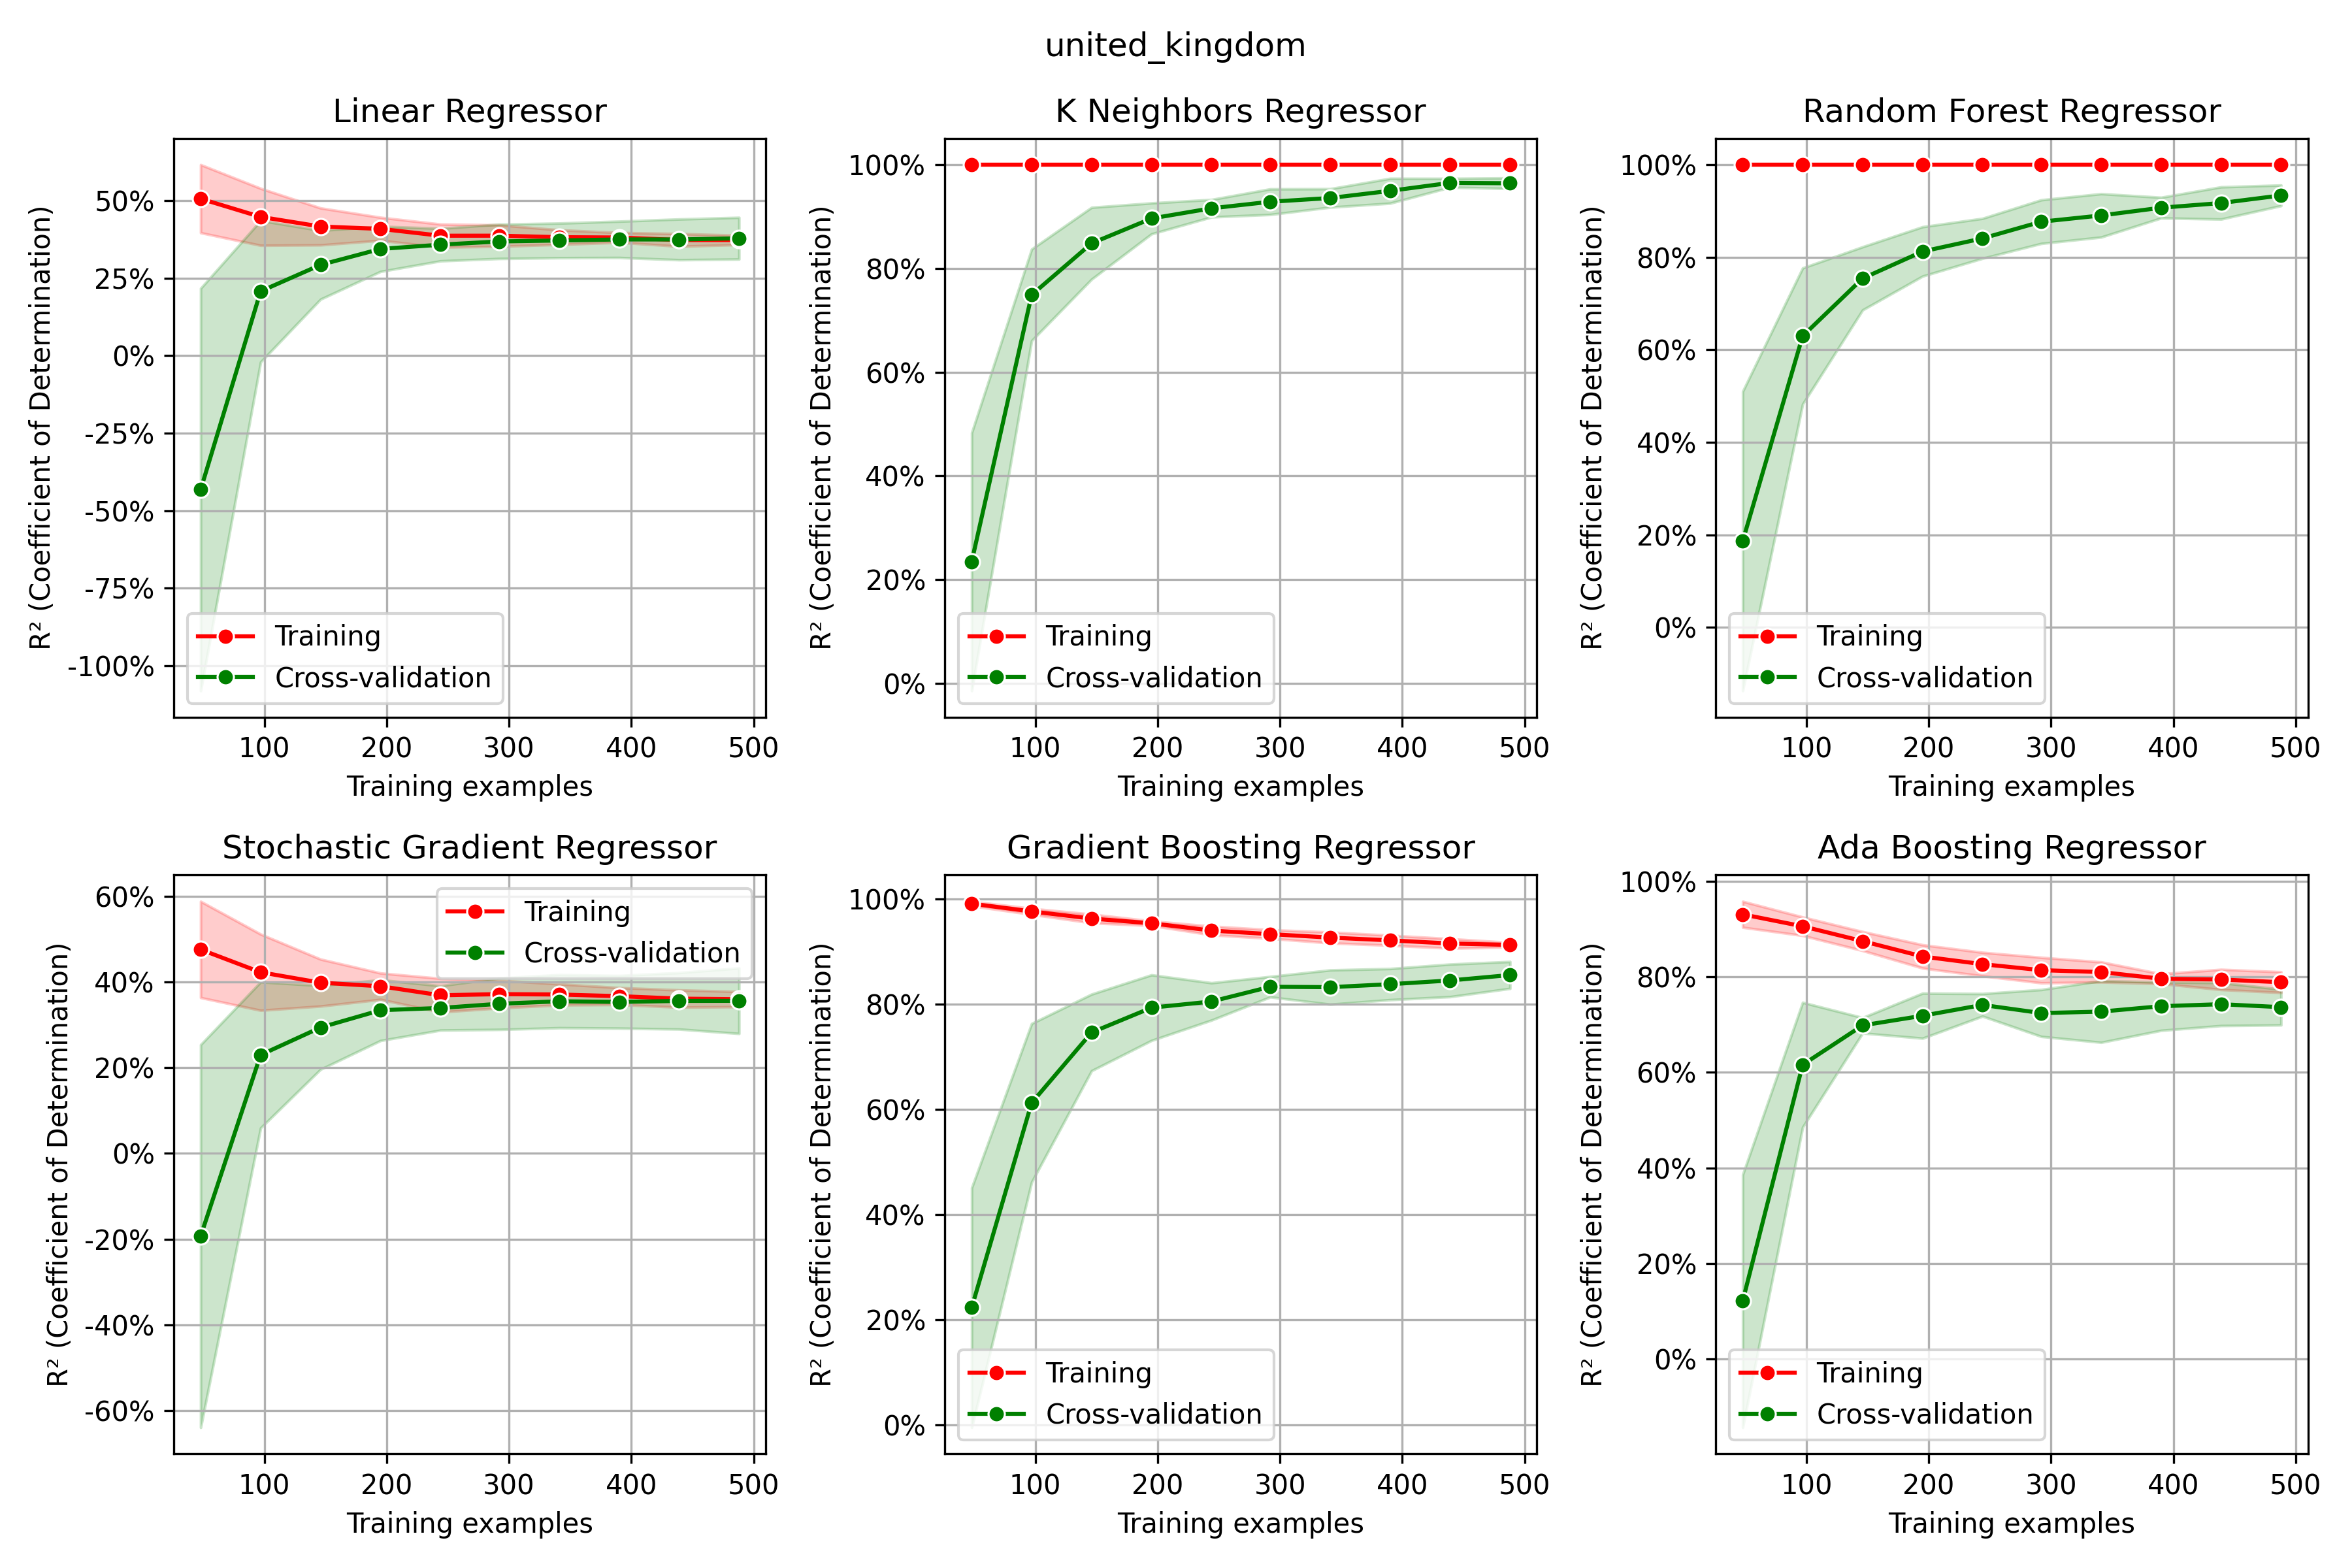

In [8]:
Image("./images/united_kingdom_learning_curves.png",width=800, height=800)

### Features Importance

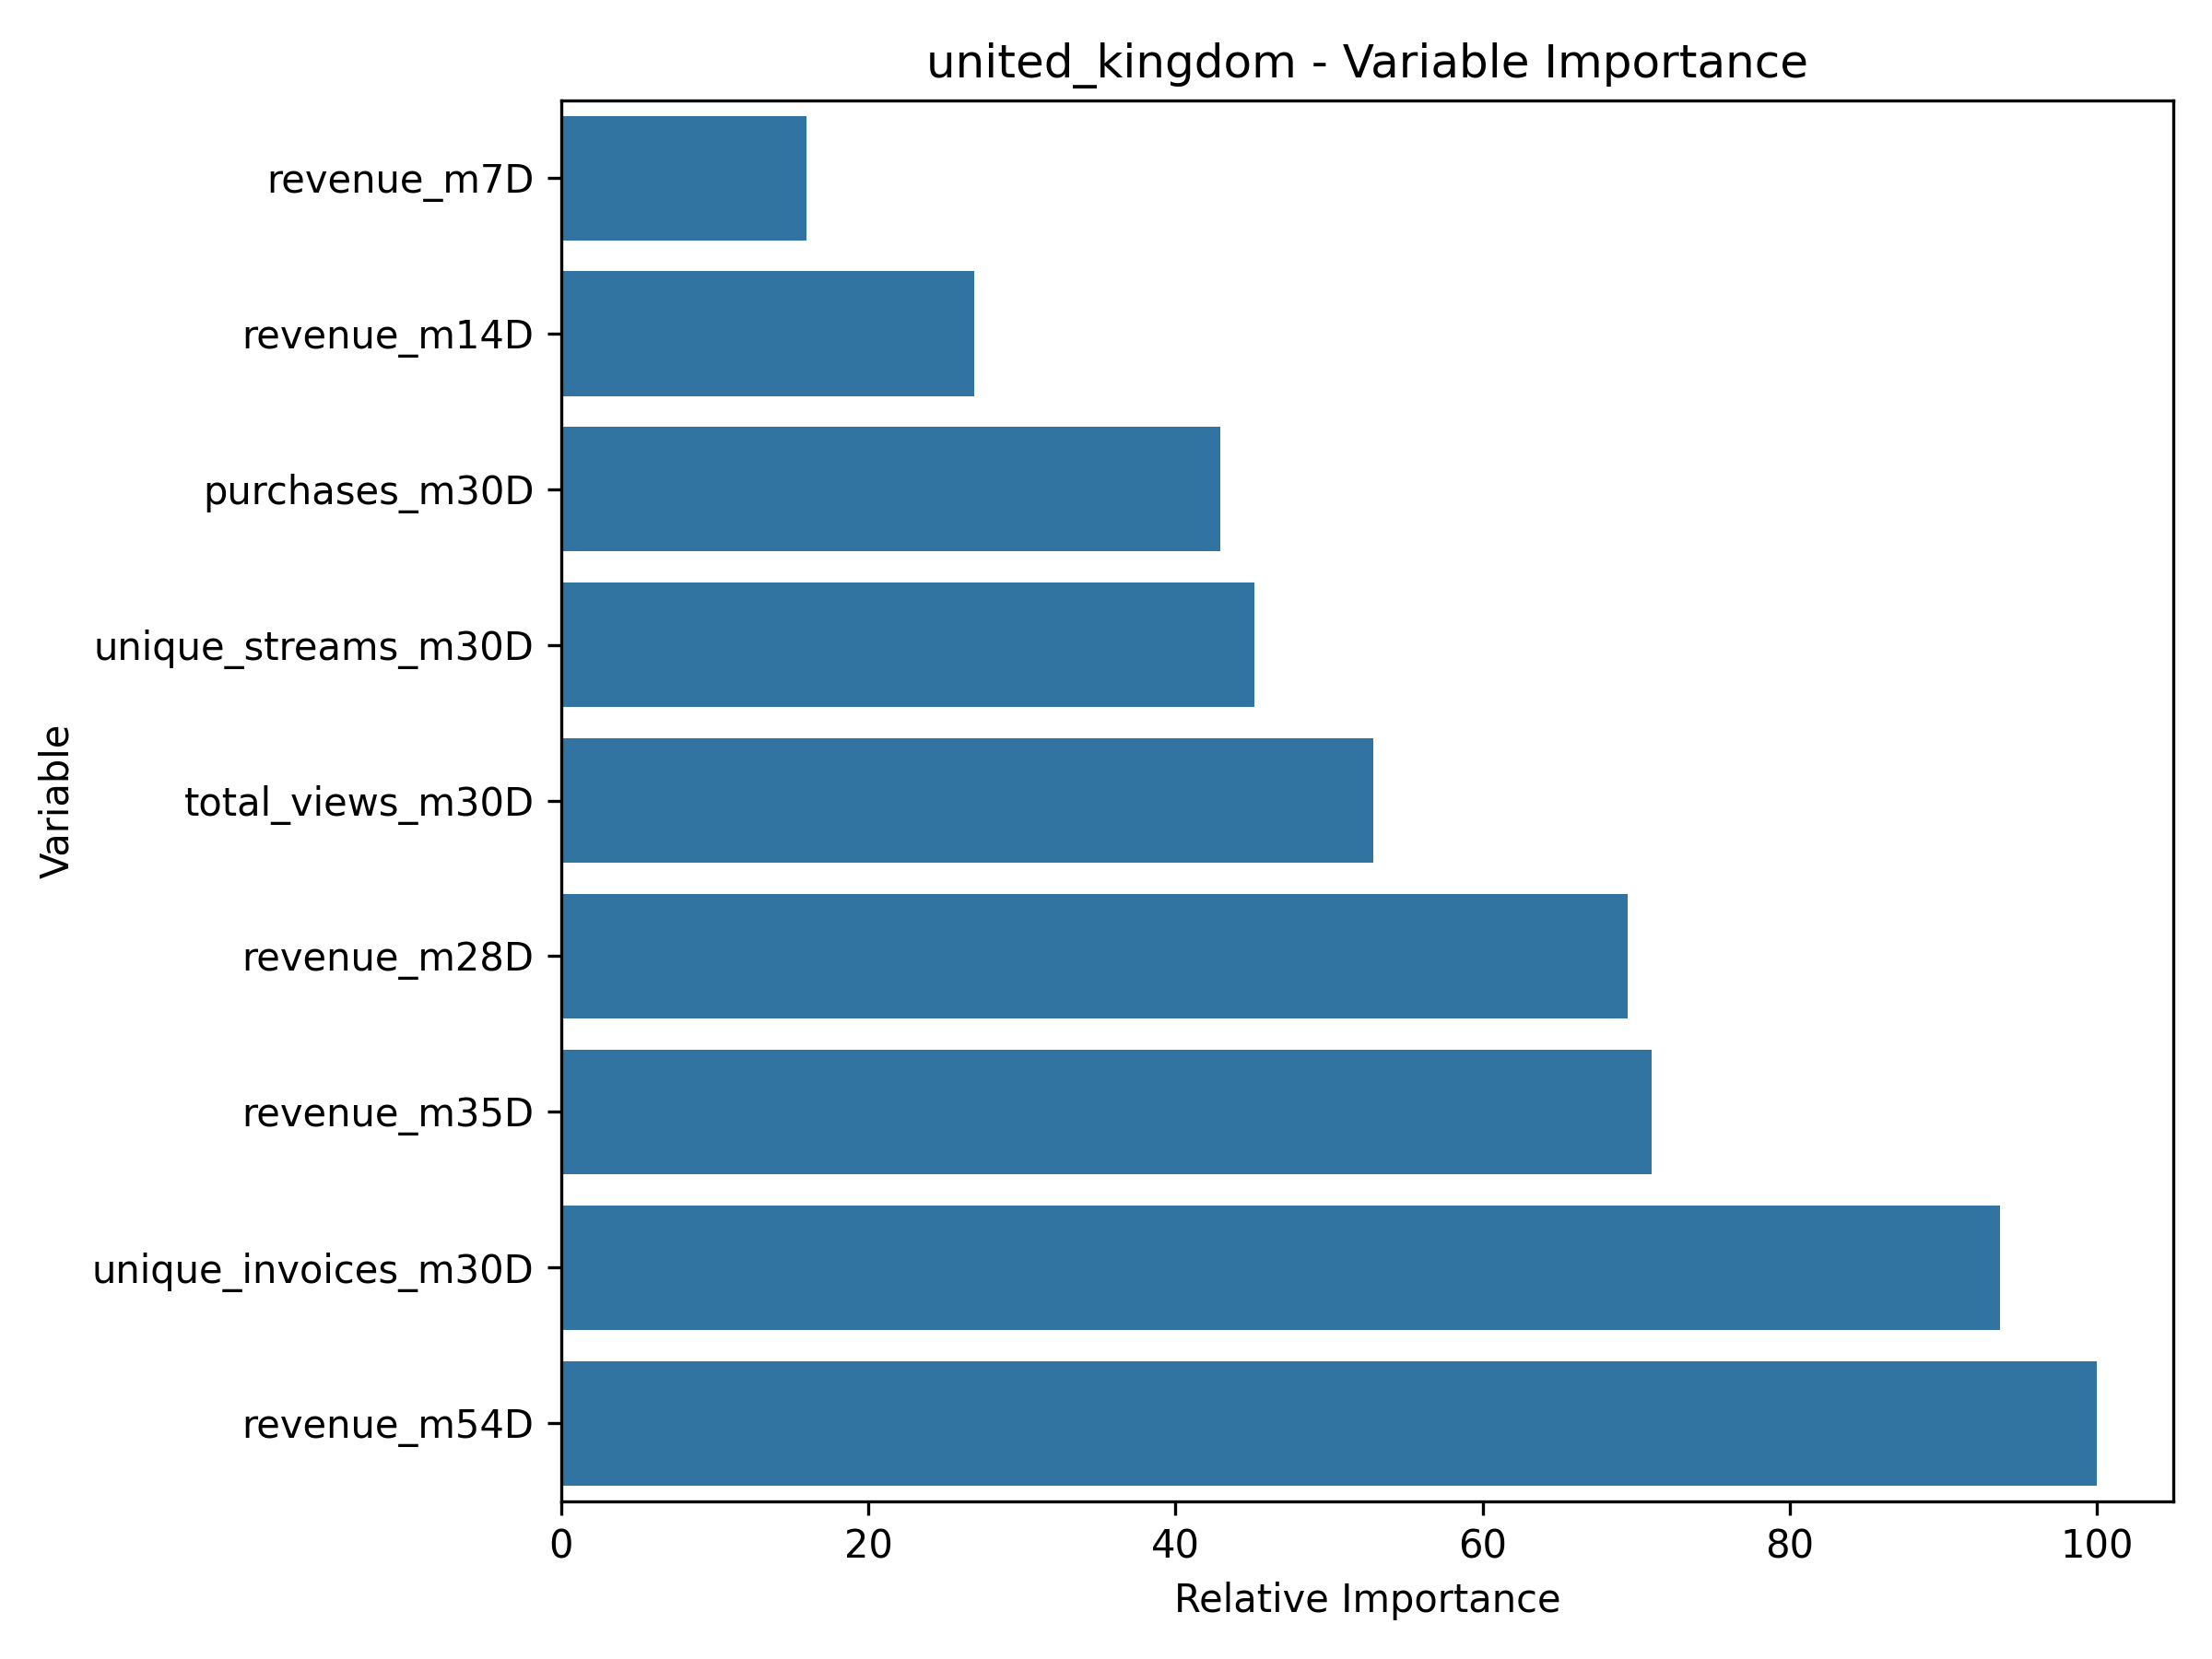

In [9]:
Image("./images/united_kingdom_features_importance.png",width=800, height=800)

### Model Overview

In [10]:
models = model_load()

labels = {}
for key, item in models.items():
    labels[key.upper()] = type(item.best_estimator_["reg"]).__name__
    
bm = pd.DataFrame.from_dict(labels, orient="index", columns=["model"])
bm

Loading Models


,model
ALL,KNeighborsRegressor
EIRE,RandomForestRegressor
FRANCE,RandomForestRegressor
GERMANY,KNeighborsRegressor
HONG_KONG,RandomForestRegressor
NETHERLANDS,KNeighborsRegressor
NORWAY,AdaBoostRegressor
PORTUGAL,RandomForestRegressor
SINGAPORE,AdaBoostRegressor
SPAIN,KNeighborsRegressor


[EOF]